# Differences between ``AngularModel`` and ``LinearModel``

In this notebook, simple 1-dimensional models are tested and compared.

In [1]:
from qrobot.models import LinearModel, AngularModel

## Models differences

The Models operate different angle encodings:

- given a scalar input $x$, the ``AngularModel`` encodes it with a $\theta$ angle of

$$ \theta(x) = \frac{\pi x}{\tau}$$

- given a scalar input $x$, the ``LinearModel`` encodes it with a $\theta$ angle of

$$ \theta(x) = \frac{\sin^{-1}(2x-1)+\frac{\pi}{2}}{\tau}$$

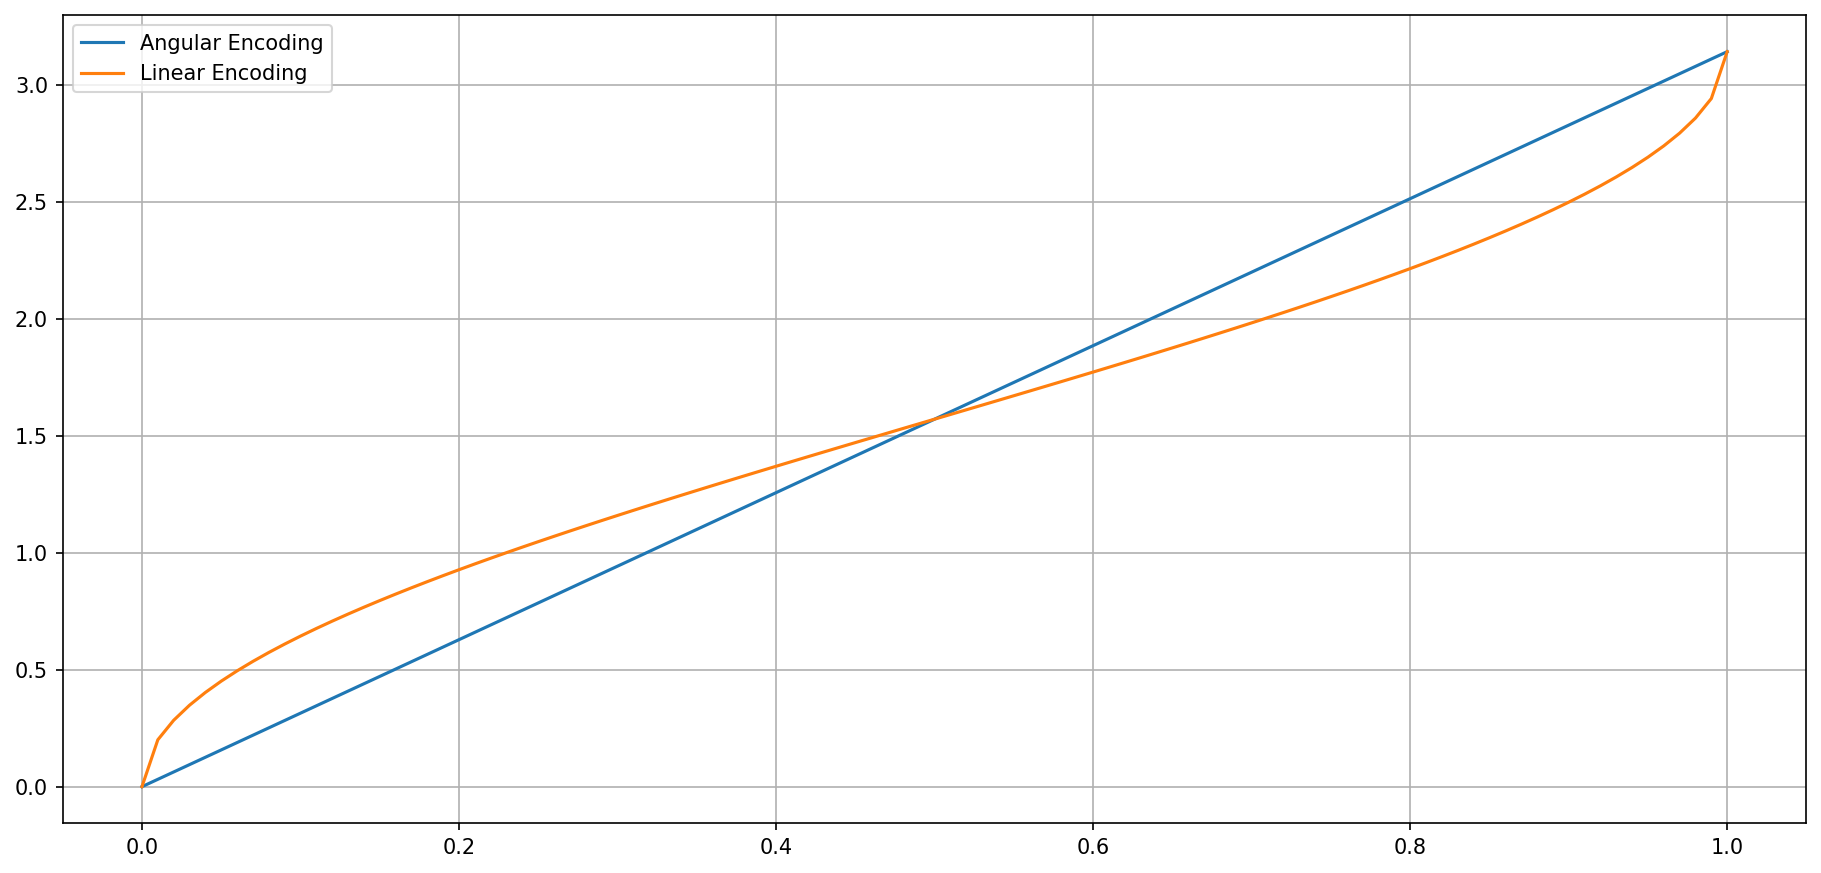

In [2]:
import numpy as np
import matplotlib.pyplot as plt

X = [x / 100 for x in range(0, 101)]
Y_angular = [np.pi * x for x in X]
Y_linear = [np.arcsin(2 * x - 1) + np.pi / 2 for x in X]
plt.figure(figsize=(15, 7), dpi=150)
plt.plot(X, Y_angular)
plt.plot(X, Y_linear)
plt.legend(["Angular Encoding", "Linear Encoding"])
plt.grid()
plt.show()

The decoding by means of the measurement probability is:
$$ \text{Probability of measuring } \lvert 1 \rangle = \sin^2 \left( \frac{\theta}{2} \right)$$

Hence, for $\tau = 1$ the ``LinearModel`` elicitates the non-linearity by inverting it:

$$ \text{Prob. } \lvert 1 \rangle = \sin^2 \left(\frac{\sin^{-1}(2x-1)+\frac{\pi}{2}}{2} \right) = x$$

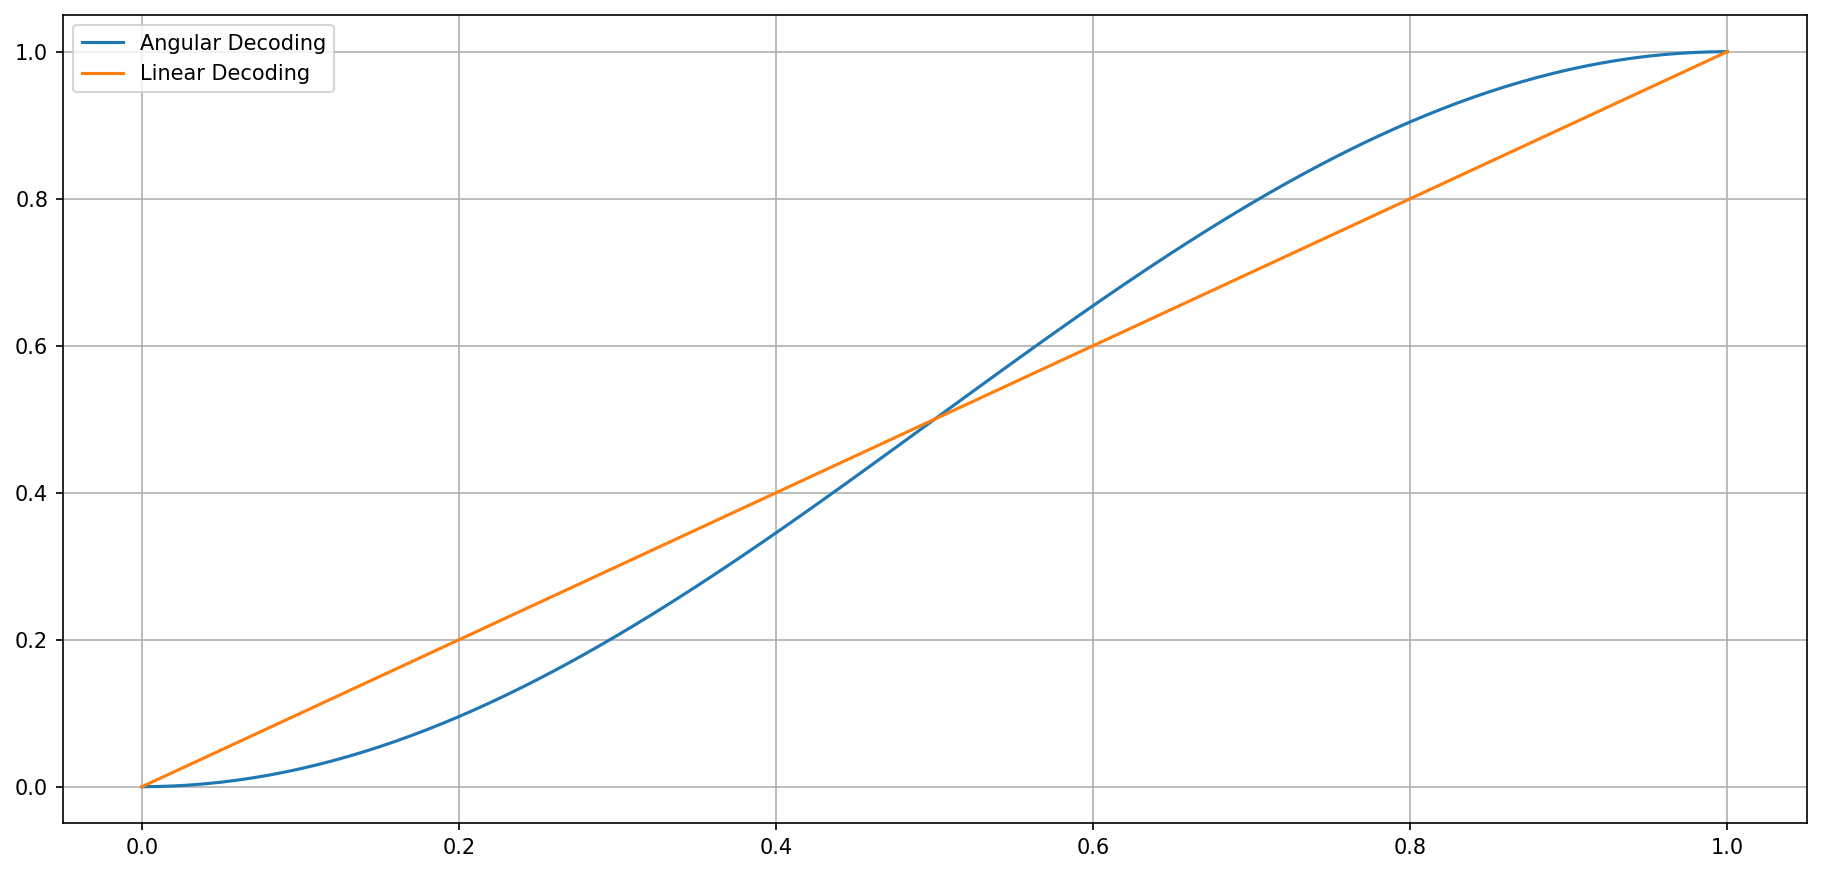

In [3]:
X = [x / 100 for x in range(0, 101)]
Y_angular = [np.square(np.sin((np.pi * x) / 2)) for x in X]
Y_linear = [np.square(np.sin((np.arcsin(2 * x - 1) + np.pi / 2) / 2)) for x in X]
plt.figure(figsize=(15, 7), dpi=150)
plt.plot(X, Y_angular)
plt.plot(X, Y_linear)
plt.legend(["Angular Decoding", "Linear Decoding"])
plt.grid()
plt.show()

**BEWARE**: for $\tau > 1$ the ``LinearModel`` loses its linearity:

$$ \text{Prob. } \lvert 1 \rangle = \sin^2 \left(\frac{\sin^{-1}(2x-1)+\frac{\pi}{2}}{2 \tau} \right) \neq x !!!$$

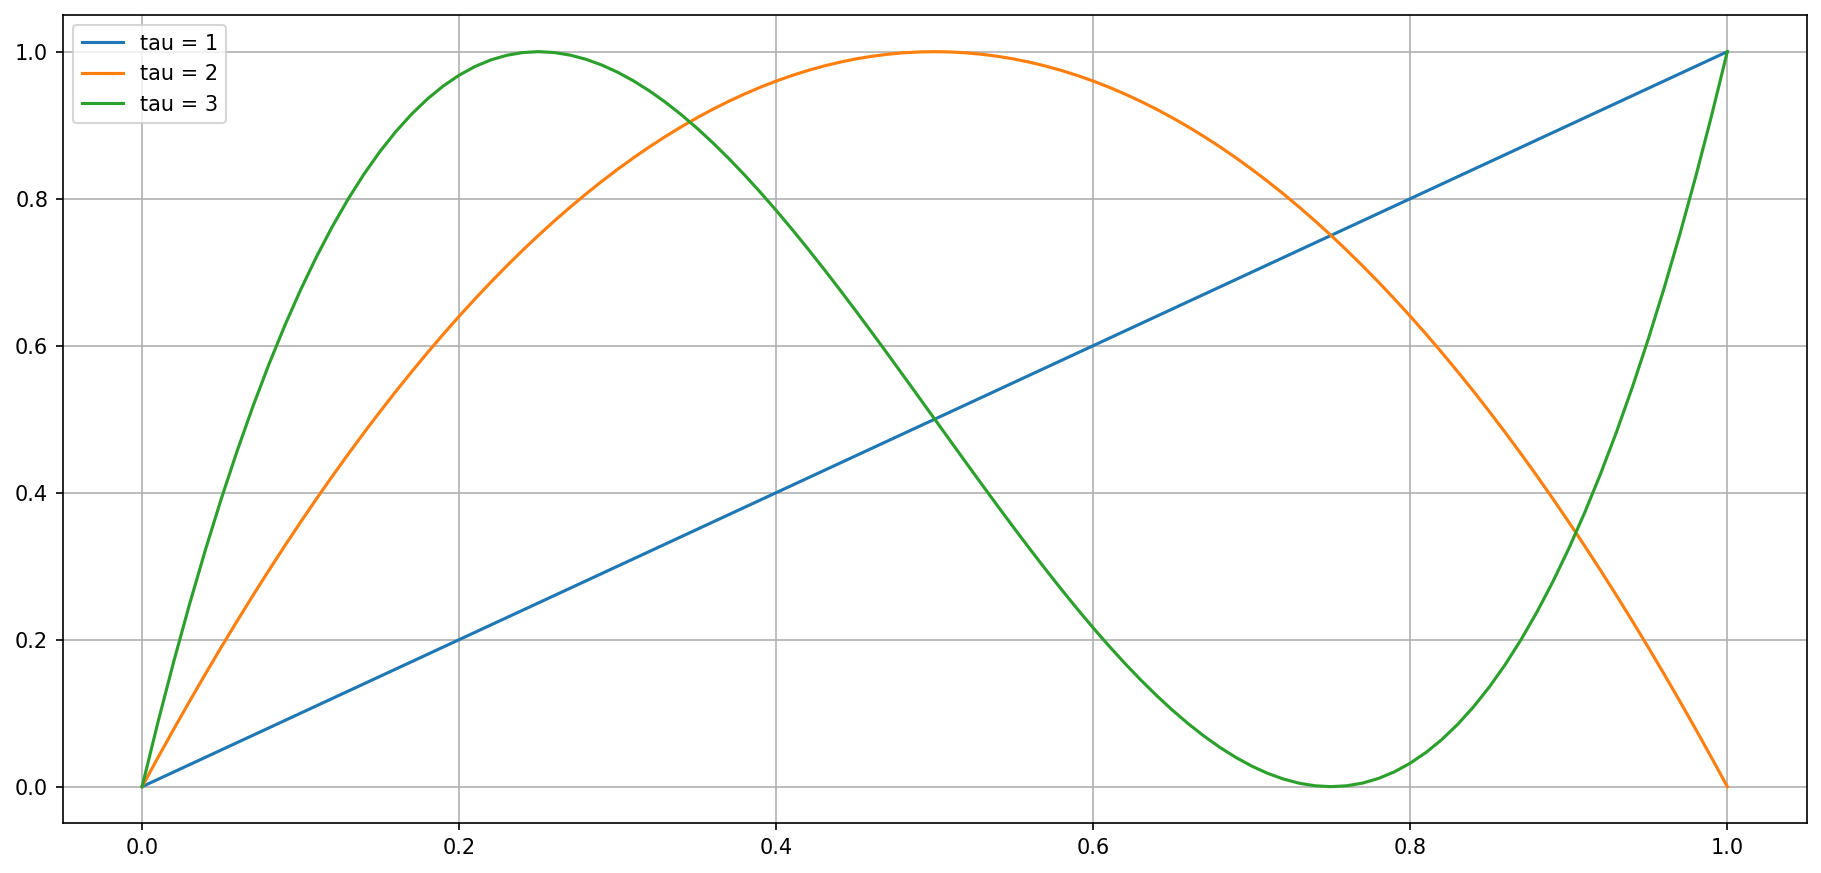

In [4]:
max_tau = 3

X = [x / 100 for x in range(0, 101)]
Y = list()
for tau in range(1, max_tau + 1):
    Y.append(
        [np.square(np.sin((np.arcsin(2 * x - 1) + np.pi / 2) / 2 * tau)) for x in X]
    )

plt.figure(figsize=(15, 7), dpi=150)
labels = list()
for i in range(0, max_tau):
    plt.plot(X, Y[i])
    plt.grid()
    labels.append(f"tau = {i+1}")
plt.legend(labels)
plt.show()

## Input Test

This test will compare the state outcome probability for the Angular (left) and the Linear (right) models for a certain number of input samples $x$ between 0 and 1 include given a fixed $\tau$

In [5]:
input_samples = 10

### $\tau$ = 1


In [6]:
tau = 1

In [7]:
import pandas as pd


def test_concat_counts(dataframe, counts, label_name, label_value, shots):
    # Store in the dataset (normalizing probabilities)
    counts[label_name] = label_value
    try:
        counts["0"] = counts["0"] / shots
    except KeyError:
        counts["0"] = 0
    try:
        counts["1"] = counts["1"] / shots
    except KeyError:
        counts["1"] = 0
    # Cast counts as dataframe to concatenate them
    counts = pd.DataFrame([counts])
    dataframe = pd.concat([dataframe, pd.DataFrame(counts)], ignore_index=True)
    return dataframe


def test_input(model, input_samples, tau=1, x_label="input"):
    dataframe = pd.DataFrame()
    shots = 1000000
    inputs = [s / input_samples for s in range(0, input_samples + 1)]
    for i in inputs:
        print(f"Input = {i}  ", end="\r")
        model.clear()
        # Encode the input and measure
        for _ in range(0, tau):
            model.encode(i, dim=0)
        counts = model.measure(shots)
        dataframe = test_concat_counts(dataframe, counts, x_label, i, shots)
    print("                        ")
    return dataframe

In [8]:
df_angular_input = test_input(
    AngularModel(1, tau),
    input_samples,
    tau,
    x_label="input",
)
df_angular_input

,0,input,1
0,1.000000,0.0,0.000000
1,0.975972,0.1,0.024028
2,0.904671,0.2,0.095329
3,0.794100,0.3,0.205900
4,0.654446,0.4,0.345554
5,0.500587,0.5,0.499413
6,0.345421,0.6,0.654579
7,0.205791,0.7,0.794209
8,0.095376,0.8,0.904624
9,0.024556,0.9,0.975444


In [9]:
df_linear_input = test_input(
    LinearModel(1, tau),
    input_samples,
    tau,
    x_label="input",
)
df_linear_input

,0,input,1
0,1.000000,0.0,0.000000
1,0.900193,0.1,0.099807
2,0.800332,0.2,0.199668
3,0.699811,0.3,0.300189
4,0.600502,0.4,0.399498
5,0.499384,0.5,0.500616
6,0.400008,0.6,0.599992
7,0.300530,0.7,0.699470
8,0.199834,0.8,0.800166
9,0.099431,0.9,0.900569


In [10]:
def plot_versus(dataframe1, dataframe2, x_label):
    plt.figure(figsize=(15, 4), dpi=150)
    plt.grid(linestyle="--", linewidth=1)

    plt.subplot(1, 2, 1)
    dataframe1.plot(x=x_label, y=["0", "1"], kind="line", ax=plt.gca())
    plt.legend(["|0>", "|1>"])
    plt.grid()

    plt.subplot(1, 2, 2)
    dataframe2.plot(x=x_label, y=["0", "1"], kind="line", ax=plt.gca())
    plt.legend(["|0>", "|1>"])
    plt.grid()

    plt.show()

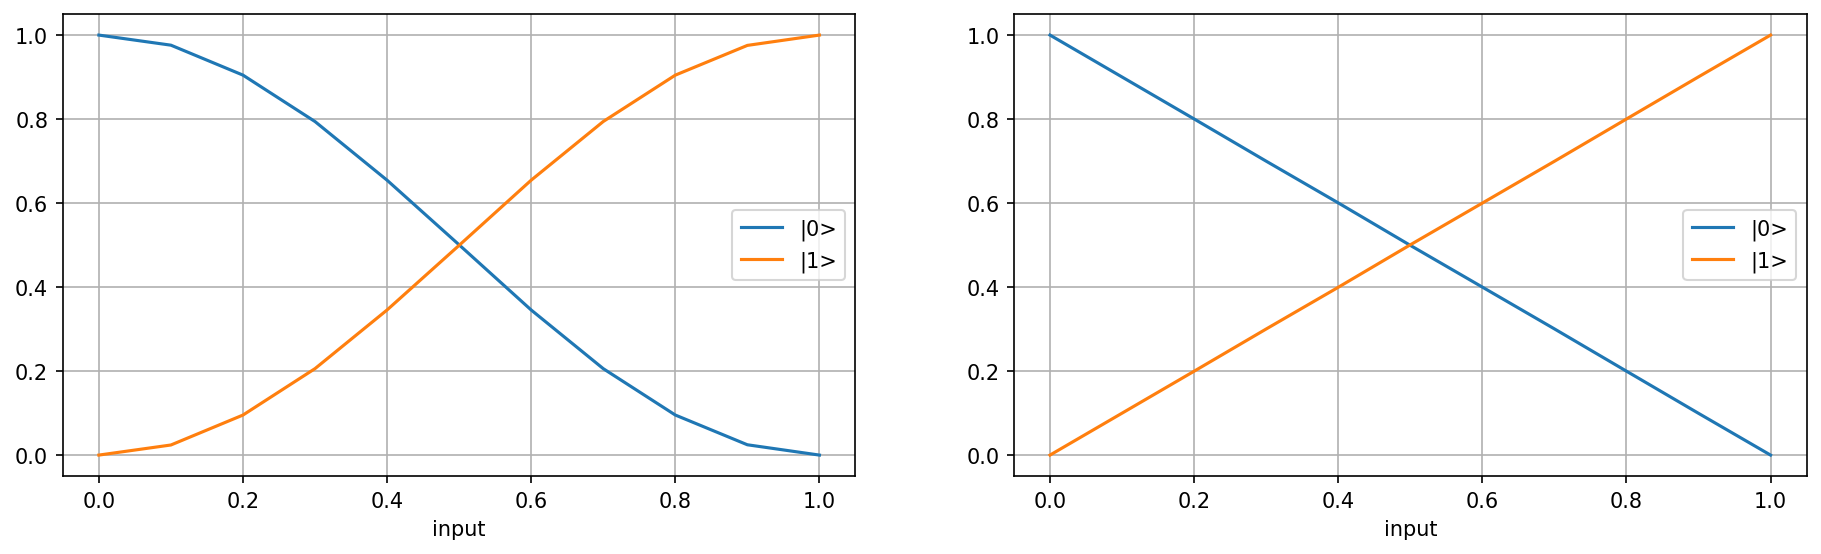

In [11]:
plot_versus(
    df_angular_input,
    df_linear_input,
    x_label="input",
)

### $\tau$ = 10


In [12]:
tau = 10

In [13]:
df_angular_input = test_input(AngularModel(1, tau), input_samples, tau, x_label="input")
df_linear_input = test_input(LinearModel(1, tau), input_samples, tau, x_label="input")

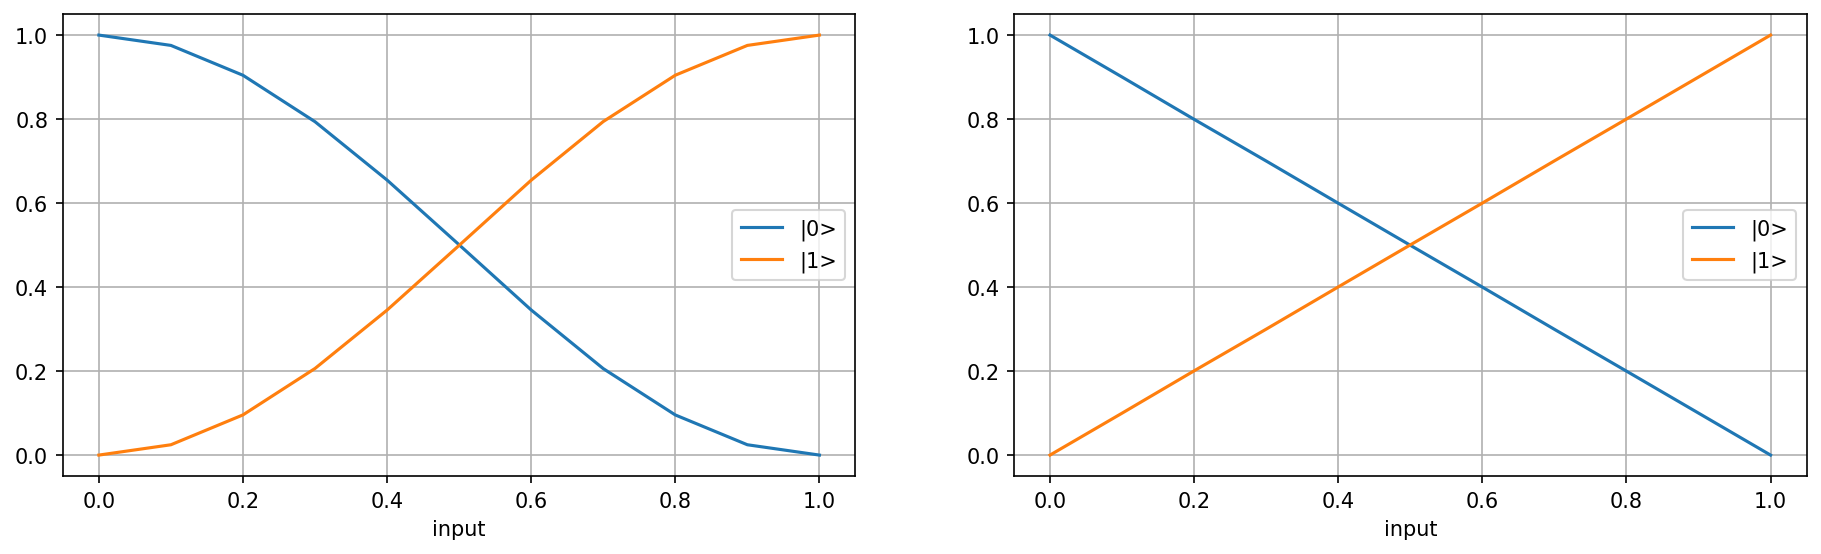

In [14]:
plot_versus(df_angular_input, df_linear_input, x_label="input")

## Queries Test

This test will compare the state outcome probability for the Angular (left) and the Linear (right) models for input samples $x=0.5$ after a query between 0 and 1 performed on the system (the plots represent different queries sampled between 0 and 1). $\tau$ is considered fixed at $\tau = 1$

In [15]:
query_samples = 10

In [16]:
def test_query(model, query_samples, x_label="query"):
    dataframe = pd.DataFrame()
    shots = 1000000
    queries = [s / query_samples for s in range(0, query_samples + 1)]
    for query in queries:
        print(f"Query = {query}  ", end="\r")
        model.clear()
        # Encode always .5 events
        model.encode(0.5, dim=0)
        # then apply the query
        model.query([query])
        # and measure
        counts = model.measure(shots)
        dataframe = test_concat_counts(dataframe, counts, x_label, query, shots)
    print("                        ")
    return dataframe

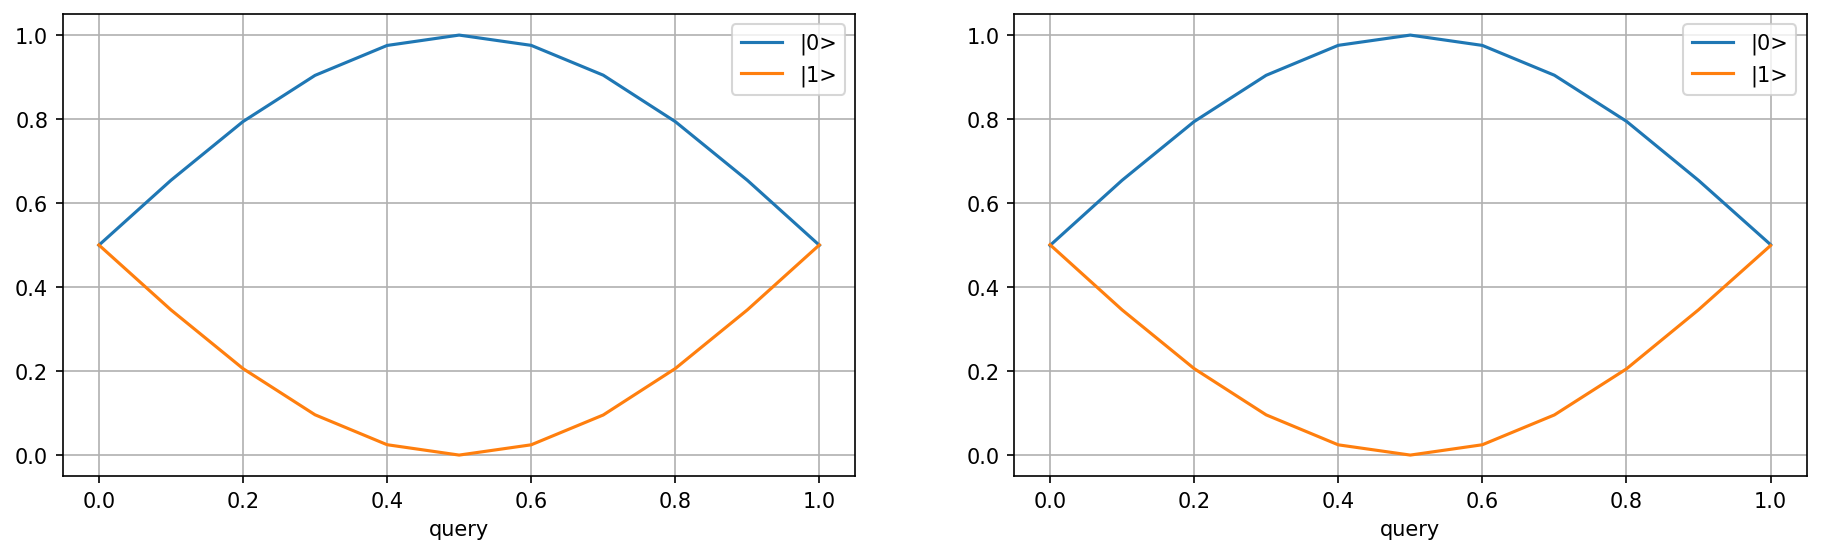

In [17]:
df_angular_query = test_query(AngularModel(1, 1), query_samples, x_label="query")
df_linear_query = test_query(LinearModel(1, 1), query_samples, x_label="query")
plot_versus(df_angular_query, df_linear_query, x_label="query")

## $\tau_{\uparrow}$ Test

$\tau_{\uparrow} \leq  \tau$ is the number of events $x=$ ``intensity`` in a sequence of $\tau$ events (the remaining events are $x=0$). 

For example, considering a sequence long $\tau = 5$, with $\tau_{\uparrow} = 3$ events of ``intensity`` $=0.8$, a possible actual sequence could be:

$$[\; 0.8 \;, \; 0.8 \;, \; 0.8 \;, \; 0.0 \;, \; 0.0\; ]$$

In [18]:
tau = 10

In [19]:
def test_tau_up(model, intensity=1, x_label="tau_up"):
    dataframe = pd.DataFrame()
    shots = 1000000
    for tau_up in range(0, model.tau + 1):
        print(f"Tau_up = {tau_up}/{model.tau}    ", end="\r")
        model.clear()
        # Encode the tau_up events
        for _ in range(0, tau_up):
            model.encode(intensity, dim=0)
        counts = model.measure(shots)
        dataframe = test_concat_counts(dataframe, counts, x_label, tau_up, shots)
    print("                        ")
    return dataframe

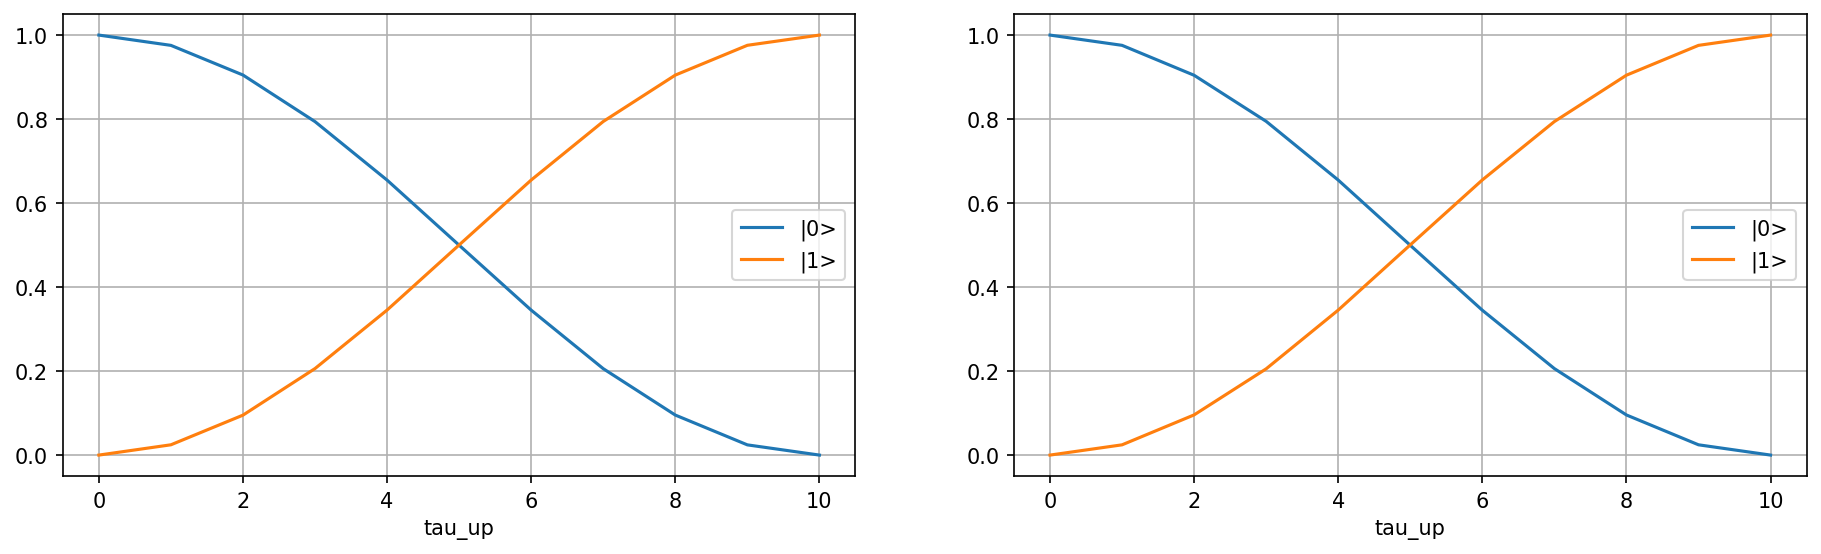

In [20]:
df_angular_tau_up = test_tau_up(AngularModel(1, tau), intensity=1, x_label="tau_up")
df_linear_tau_up = test_tau_up(LinearModel(1, tau), intensity=1, x_label="tau_up")
plot_versus(df_angular_tau_up, df_linear_tau_up, x_label="tau_up")

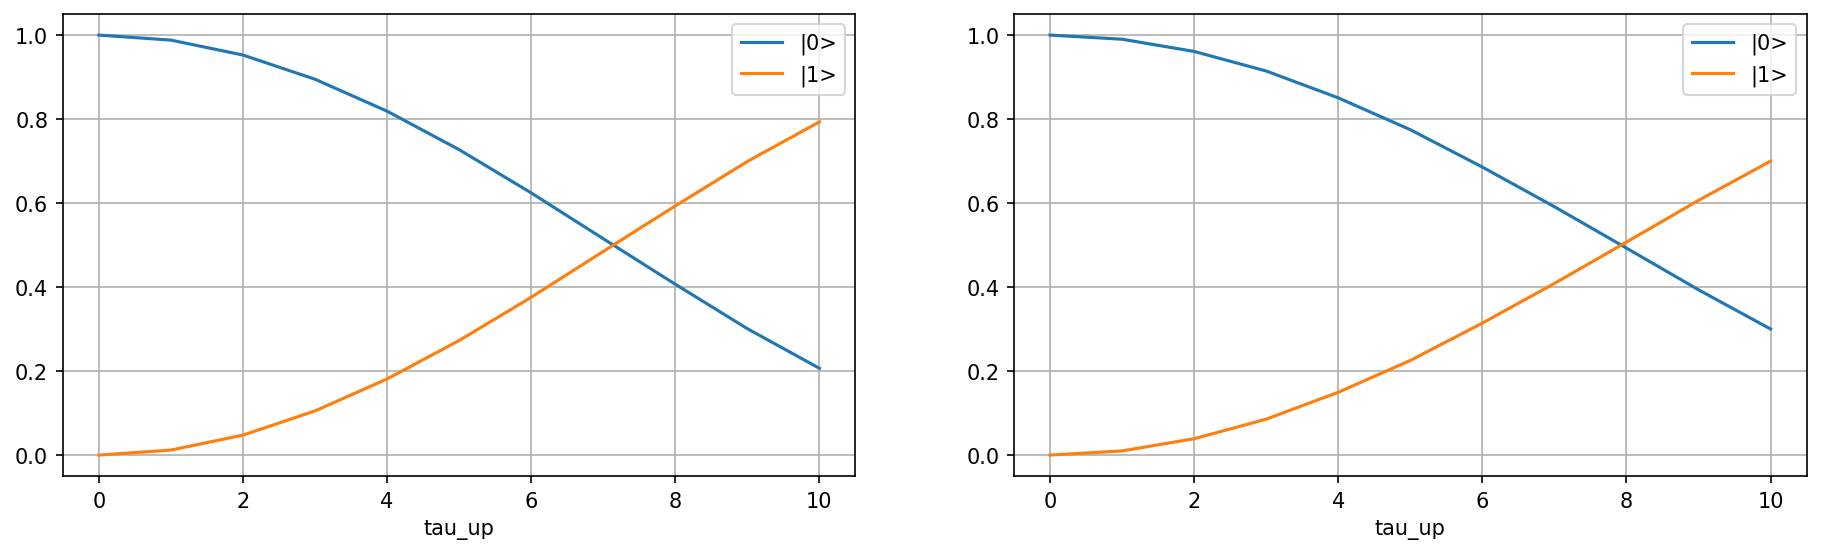

In [21]:
df_angular_tau_up = test_tau_up(AngularModel(1, tau), intensity=0.7, x_label="tau_up")
df_linear_tau_up = test_tau_up(LinearModel(1, tau), intensity=0.7, x_label="tau_up")
plot_versus(df_angular_tau_up, df_linear_tau_up, x_label="tau_up")

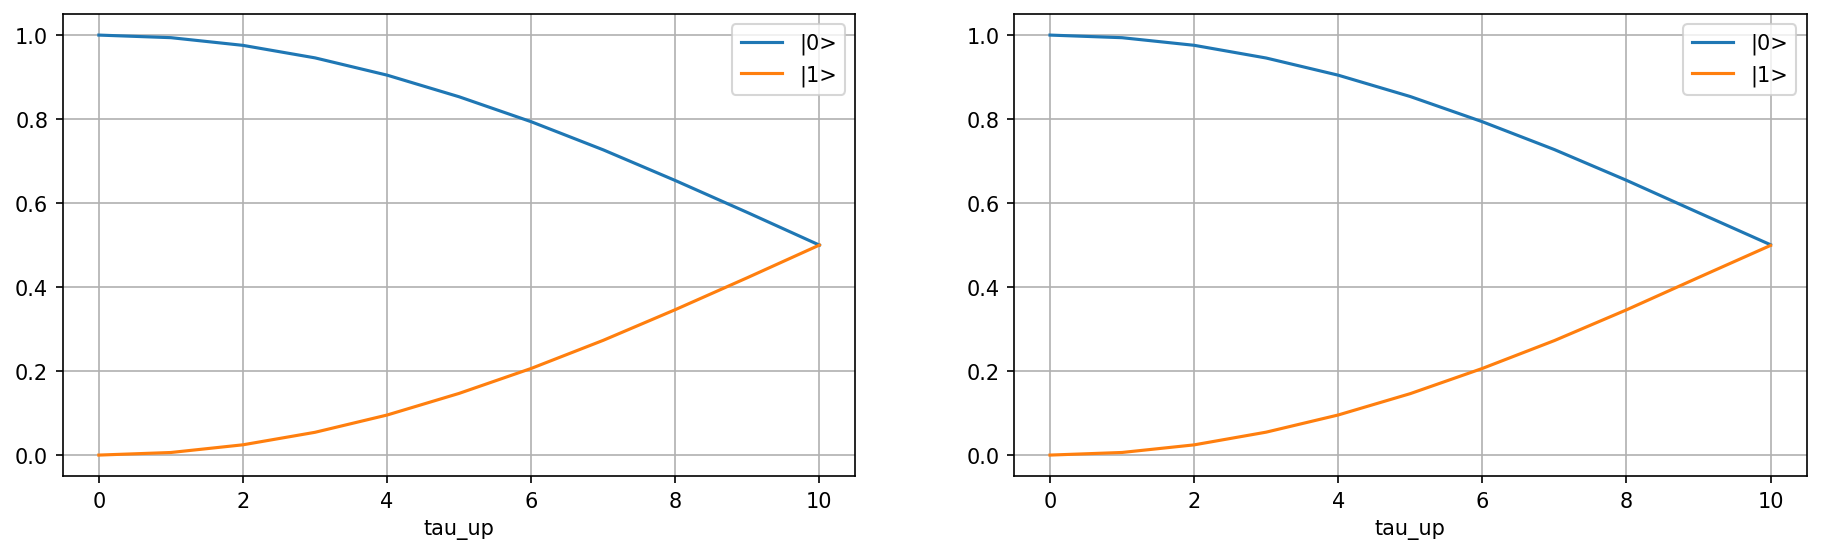

In [22]:
df_angular_tau_up = test_tau_up(AngularModel(1, tau), intensity=0.5, x_label="tau_up")
df_linear_tau_up = test_tau_up(LinearModel(1, tau), intensity=0.5, x_label="tau_up")
plot_versus(df_angular_tau_up, df_linear_tau_up, x_label="tau_up")

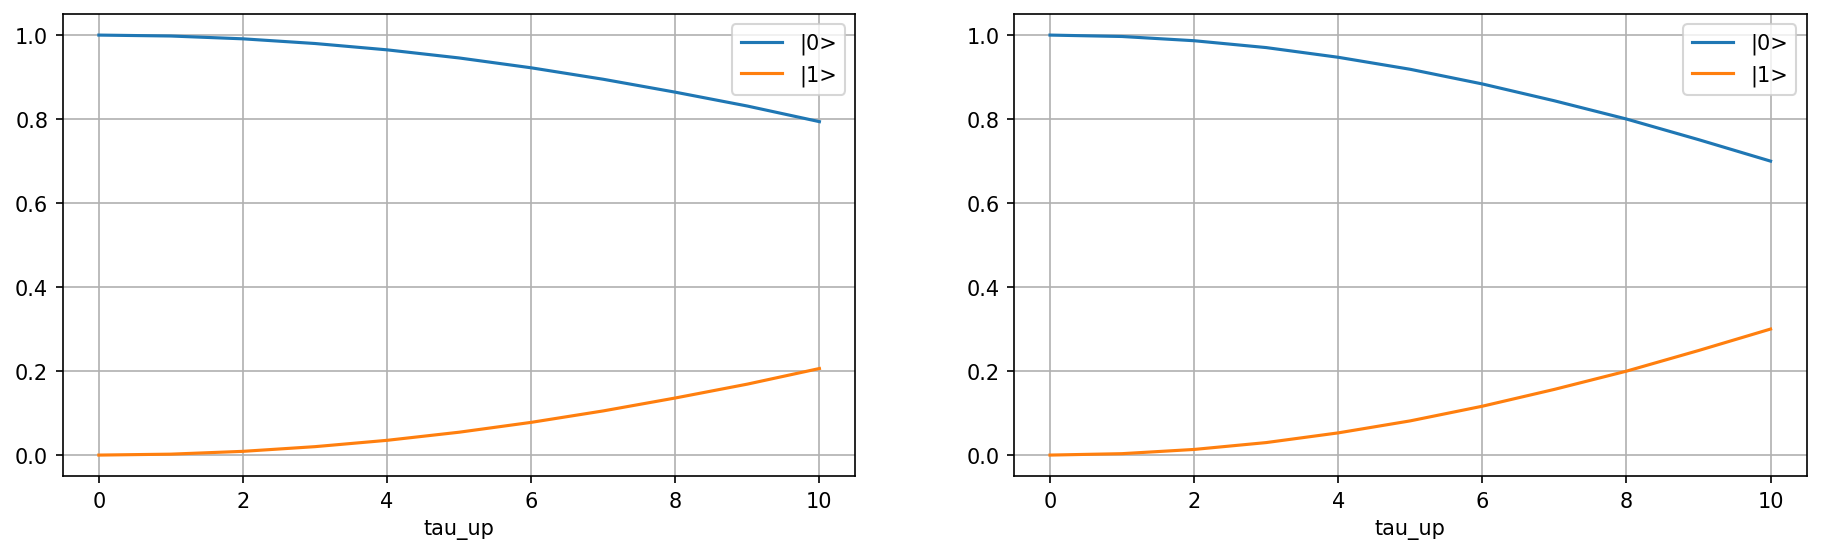

In [23]:
df_angular_tau_up = test_tau_up(AngularModel(1, tau), intensity=0.3, x_label="tau_up")
df_linear_tau_up = test_tau_up(LinearModel(1, tau), intensity=0.3, x_label="tau_up")
plot_versus(df_angular_tau_up, df_linear_tau_up, x_label="tau_up")